Taken from: https://www.kaggle.com/code/markishere/day-3-function-calling-with-the-gemini-api

In [1]:
import google.generativeai as genai
import os

In [2]:
GOOGLE_API_KEY = os.environ["SECRET_GEMINI_KEY"]
genai.configure(api_key=GOOGLE_API_KEY)

# Create a local database
For this minimal example, you'll create a local SQLite database and add some synthetic data so you have something to query.

Load the sql IPython extension so you can interact with the database using magic commands (the % instructions) to create a new, empty SQLite database.

In [ ]:
!pip install ipython-sql

In [3]:
# Load the sql extension
%load_ext sql

In [4]:
%sql sqlite:///sample.db


Create the tables and insert some synthetic data. Feel free to tweak this structure and data.

In [5]:
%%sql
-- Create the 'products' table
CREATE TABLE IF NOT EXISTS products (
  	product_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	product_name VARCHAR(255) NOT NULL,
  	price DECIMAL(10, 2) NOT NULL
  );

-- Create the 'staff' table
CREATE TABLE IF NOT EXISTS staff (
  	staff_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	first_name VARCHAR(255) NOT NULL,
  	last_name VARCHAR(255) NOT NULL
  );

-- Create the 'orders' table
CREATE TABLE IF NOT EXISTS orders (
  	order_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	customer_name VARCHAR(255) NOT NULL,
  	staff_id INTEGER NOT NULL,
  	product_id INTEGER NOT NULL,
  	FOREIGN KEY (staff_id) REFERENCES staff (staff_id),
  	FOREIGN KEY (product_id) REFERENCES products (product_id)
  );

-- Insert data into the 'products' table
INSERT INTO products (product_name, price) VALUES
  	('Laptop', 799.99),
  	('Keyboard', 129.99),
  	('Mouse', 29.99);

-- Insert data into the 'staff' table
INSERT INTO staff (first_name, last_name) VALUES
  	('Alice', 'Smith'),
  	('Bob', 'Johnson'),
  	('Charlie', 'Williams');

-- Insert data into the 'orders' table
INSERT INTO orders (customer_name, staff_id, product_id) VALUES
  	('David Lee', 1, 1),
  	('Emily Chen', 2, 2),
  	('Frank Brown', 1, 3);

 * sqlite:///sample.db
Done.
Done.
Done.
3 rows affected.
3 rows affected.
3 rows affected.


[]

# Define database functions
Function calling with Gemini API's Python SDK can be implemented by defining an OpenAPI schema that is passed to the model. Alternatively you can define Python functions and let the SDK inspect them to automatically define the schema. In this latter case, it's important that the functions are type annotated and have accurate docstrings that describe what the functions do - the model has no insight into the function body, so the docs function as the interface.

By providing three key pieces of functionality - listing tables, describing a table, and executing a query - the LLM (or even another user) will have the basic tools needed to understand and interrogate the database.

Start with a database connection that will be used across all of the functions.

In [6]:
import sqlite3

db_file = "sample.db"
db_conn = sqlite3.connect(db_file)

The first function will list all tables available in the database. Define it, and test it out to ensure it works.



In [7]:
def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    # Include print logging statements so you can see when functions are being called.
    print(' - DB CALL: list_tables')

    cursor = db_conn.cursor()

    # Fetch the table names.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    return [t[0] for t in tables]


list_tables()

 - DB CALL: list_tables


['products', 'sqlite_sequence', 'staff', 'orders']

Once the available tables is known, the next step a database user will need is to understand what columns are available in a given table. Define that too, and test that it works as expected.

In [8]:
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.

    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    print(' - DB CALL: describe_table')

    cursor = db_conn.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2]) for col in schema]


describe_table("products")

 - DB CALL: describe_table


[('product_id', 'INTEGER'),
 ('product_name', 'VARCHAR(255)'),
 ('price', 'DECIMAL(10, 2)')]

Now that the system knows what tables and columns are present, it has enough information to be able to generate and run a `SELECT` query. Now provide that functionality, and test that it works.

In [9]:
def execute_query(sql: str) -> list[list[str]]:
    """Execute a SELECT statement, returning the results."""
    print(' - DB CALL: execute_query')

    cursor = db_conn.cursor()

    cursor.execute(sql)
    return cursor.fetchall()


execute_query("select * from products")

 - DB CALL: execute_query


[(1, 'Laptop', 799.99), (2, 'Keyboard', 129.99), (3, 'Mouse', 29.99)]

# Implement function calls

Now you can put it all together in a call to the Gemini API.

Function calling works by adding specific messages to a chat session. When function schemas are defined and made available to the model and a conversation is started, instead of returning a text response, the model may return a function_call instead. When this happens, the client must respond with a function_response, indicating the result of the call, and the conversation can continue on as normal.

This function calling interaction normally happens manually, allowing you, the client, to validate and initiate the call. However the Python SDK also supports automatic function calling, where the supplied functions will be automatically invoked. This is a powerful feature and should only be exposed when it is safe to do so, such as when the functions have no side-effects).

Here's the state diagram representing the conversation flow with function calling. With automatic function calling, the bottom row is executed automatically by the Python SDK. In manual function calling, you write the code to run each step individually.

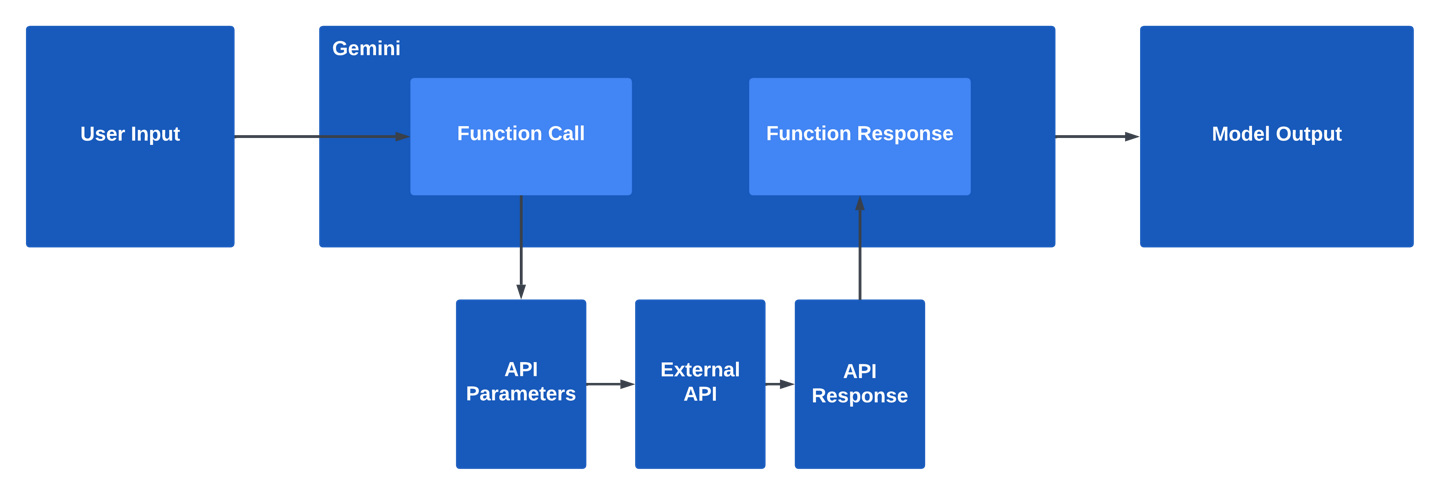

In [10]:
# These are the Python functions defined above.
db_tools = [list_tables, describe_table, execute_query]

instruction = """You are a helpful chatbot that can interact with an SQL database for a computer
store. You will take the users questions and turn them into SQL queries using the tools
available. Once you have the information you need, you will answer the user's question using
the data returned. Use list_tables to see what tables are present, describe_table to understand
the schema, and execute_query to issue an SQL SELECT query."""

model = genai.GenerativeModel(
    "models/gemini-1.5-flash-latest", tools=db_tools, system_instruction=instruction
)

# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

# Start a chat with automatic function calling enabled.
chat = model.start_chat(enable_automatic_function_calling=True)

In [15]:
db_tools

[<function __main__.list_tables() -> list[str]>,
 <function __main__.describe_table(table_name: str) -> list[tuple[str, str]]>,
 <function __main__.execute_query(sql: str) -> list[list[str]]>]

In [11]:
chat

ChatSession(
    model=genai.GenerativeModel(
        model_name='models/gemini-1.5-flash-latest',
        generation_config={},
        safety_settings={},
        tools=<google.generativeai.types.content_types.FunctionLibrary object at 0x750e00ce1dc0>,
        system_instruction="You are a helpful chatbot that can interact with an SQL database for a computer\nstore. You will take the users questions and turn them into SQL queries using the tools\navailable. Once you have the information you need, you will answer the user's question using\nthe data returned. Use list_tables to see what tables are present, describe_table to understand\nthe schema, and execute_query to issue an SQL SELECT query.",
        cached_content=None
    ),
    history=[]
)

Now you can engage in a chat conversation where you can ask about the contents of the database.



In [12]:
resp = chat.send_message("What is the cheapest product?", request_options=retry_policy)
print(resp.text)

 - DB CALL: list_tables
 - DB CALL: describe_table
 - DB CALL: execute_query
The cheapest product is the Mouse, at $29.99.



Explore the chat session and ask your own questions. If you want to try asking more complex questions, try using the gemini-1.5-pro model. It has a lower rate limit, so calls might take a bit longer on the free tier, but you'll notice an improvement in expressivity.

In [13]:
model = genai.GenerativeModel(
    "models/gemini-1.5-pro-latest", tools=db_tools, system_instruction=instruction
)

chat = model.start_chat(enable_automatic_function_calling=True)
response = chat.send_message('Which salesperson sold the cheapest product?', request_options=retry_policy)
print(response.text)

 - DB CALL: list_tables
 - DB CALL: describe_table
 - DB CALL: describe_table
 - DB CALL: describe_table
 - DB CALL: execute_query
Alice Smith sold the cheapest product.


# Inspecting the conversation
To see the calls that the model makes, and what the client returns in response, you can inspect chat.history. This helper function will print out each turn along with the relevant fields passed or returned.

In [14]:
import textwrap


def print_chat_turns(chat):
    """Prints out each turn in the chat history, including function calls and responses."""
    for event in chat.history:
        print(f"{event.role.capitalize()}:")

        for part in event.parts:
            if txt := part.text:
                print(f'  "{txt}"')
            elif fn := part.function_call:
                args = ", ".join(f"{key}={val}" for key, val in fn.args.items())
                print(f"  Function call: {fn.name}({args})")
            elif resp := part.function_response:
                print("  Function response:")
                print(textwrap.indent(str(resp), "    "))

        print()


print_chat_turns(chat)

User:
  "Which salesperson sold the cheapest product?"

Model:
  Function call: list_tables()

User:
  Function response:
    name: "list_tables"
    response {
      fields {
        key: "result"
        value {
          list_value {
            values {
              string_value: "products"
            }
            values {
              string_value: "sqlite_sequence"
            }
            values {
              string_value: "staff"
            }
            values {
              string_value: "orders"
            }
          }
        }
      }
    }


Model:
  Function call: describe_table(table_name=products)

User:
  Function response:
    name: "describe_table"
    response {
      fields {
        key: "result"
        value {
          list_value {
            values {
              list_value {
                values {
                  string_value: "product_id"
                }
                values {
                  string_value: "INTEGER"
                }


In this output you can see each of the conversational turns that were made. Note that the model doesn't remember anything outside of a ChatSession object, so you can make changes to the database structure or data and the model will respond without needing any code changes - try this out!

# Further reading

To learn more about what the Gemini API can do with function calling, check out the [Function calling cookbook](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Function_calling.ipynb) (see Manual function calling to understand how function calling works manually) as well as [Function calling config](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Function_calling_config.ipynb), which gives you fine-grained control over how function calling is triggered.